### Recurrent Neural Networks

``` Predicting the number of buses to be added to a fleet```

#### importing the neccesary libraries

In [40]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

``` Load the data from the csv and visualize the general outlook ```

In [2]:
data=pd.read_csv('data/fleet.csv')
data.head()

,Number Plate,Fleet Number
0,KBW,548P
1,KBU,282P
2,KBQ,844U
3,KBX,535W
4,KBU,838W


``` View the attributes of the data ```

In [3]:
data.describe()

,Number Plate,Fleet Number
count,60,60
unique,30,60
top,KBP,061B
freq,6,1


``` From the data we can see that there are 60 instances of the number plates with 30
unique ones for the fleet number we dont expect any duplicates as indicated by the data. we  plot the frequency each occurs ```

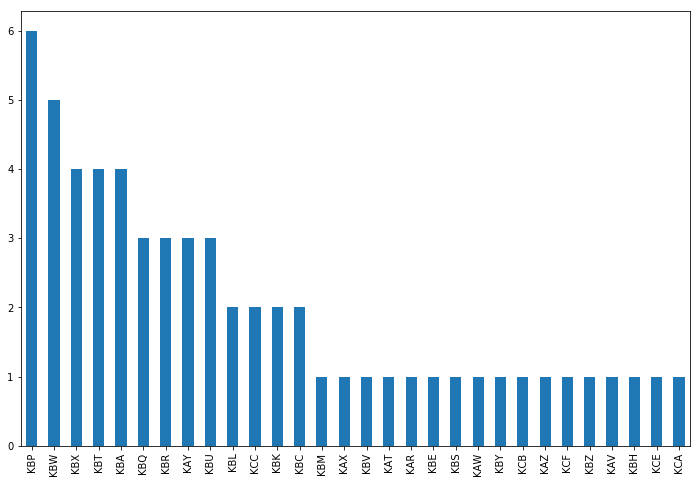

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
data['Number Plate'].value_counts().plot(ax=ax, kind='bar')

``` we can sort the data based on the number plates and make a new data frame```

In [5]:
sorted_by_number_plates=data.copy()
sorted_by_number_plates.sort_values('Number Plate',inplace=True, ascending=True)
sorted_by_number_plates=sorted_by_number_plates.reset_index(drop=True)
sorted_by_number_plates.head()

,Number Plate,Fleet Number
0,KAR,834Z
1,KAT,575Q
2,KAV,625X
3,KAW,624G
4,KAX,693P


#### get the number of KA* KB* and KC* plates

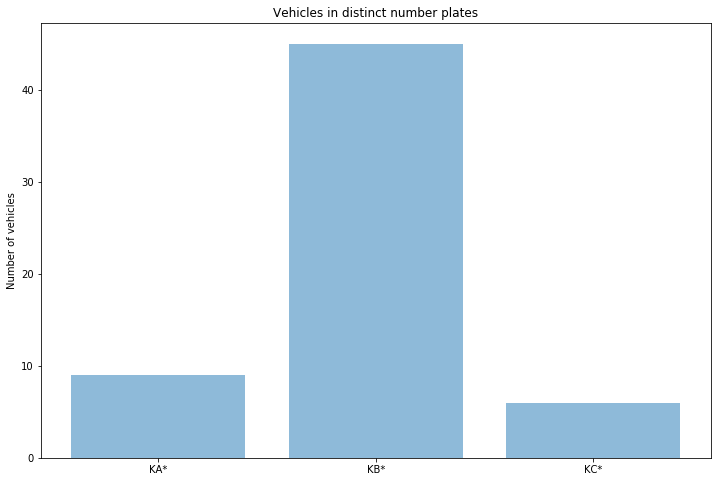

In [6]:
k_a_cars=sorted_by_number_plates['Number Plate'].apply(lambda x: re.findall("KA[a-zA-Z]+" ,x,re.M | re.I))
k_b_cars=sorted_by_number_plates['Number Plate'].apply(lambda x: re.findall("KB[a-zA-Z]+" ,x,re.M | re.I))
k_c_cars=sorted_by_number_plates['Number Plate'].apply(lambda x: re.findall("KC[a-zA-Z]+" ,x,re.M | re.I))

k_a_cars=[x for x in k_a_cars if x]
k_b_cars=[x for x in k_b_cars if x]
k_c_cars=[x for x in k_c_cars if x]


fig, ax = plt.subplots(figsize=(12, 8))
objects = ('KA*', 'KB*', 'KC*')
y_pos = np.arange(len(objects))
count = [len(k_a_cars),len(k_b_cars),len(k_c_cars)]
plt.bar(y_pos, count, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of vehicles')
plt.title('Vehicles in distinct number plates')
 
plt.show()

##### from wikipedia

```The second generation was started in 1989. The series follow KAA 001A to KAZ 999Z The present KAA xxx A series had, the advantage being that each third letter of the number provided for 23,976 registrations instead of the previous 999. Hence for ```

based on this information and assuming an 18% increase in year on year sales we can determine which years KA* cars were bought.

In [7]:
total_number_of_cars = 675324
percentage_increase=0.18 #18%
number_of_years=17 # from 1989 to 2006 when the KA* series ended




We can use the compound interest formula to compute which year a certain bus was bought
P[1+I]^T -1=Total Value
we can get P--> the principle value which in our case is the cars that were sold in 1989

In [8]:
cars_sold_in_1989=(total_number_of_cars +1) /((1+percentage_increase)**number_of_years)
cars_sold_in_1989

40505.9388794272

around 40505 cars were sold in 1989

##### given our number plates we can calculate the value held by it to determine which year  it was added to fleet

#### Methods used here are the ones used in assignment 2 

In [9]:
def vehicles_in_a_number_plate(list_a, multiplying_factors):
    """
    Return number of vehicles within the given plates
        :param list_a: A list of numbers
        :param multiplying_factors: a list of numbers
        :type list_a: list
        :type multiplying_factors: list
        :returns: a list with number of vehicles per number plate character
        :rtype: list
    """
    return [x1 * x2 for (x1, x2) in zip(list_a, multiplying_factors)]


def plate_characters(number_plate):
    """
        Return characters in a number plate
        :param number_plate: A list of numbers
        :type number_plate: list
        :returns: a list of characters in a number plate
        :rtype: list
    """
    return ''.join(re.findall("[a-zA-Z]+", number_plate, re.M | re.I))

def plate_digits(number_plate):
    """
            Return characters in a number plate
            :param number_plate: A list of string
            :type number_plate: list
            :returns: a list of  digits in  a number plate
            :rtype: list
    """
    return ''.join(re.findall("\d{3}", number_plate, re.M | re.I))

In [10]:
def get_vehicle_plate_value(number_plate):
        number_plate_a= number_plate.lower()
        characters = sorted(set(string.ascii_letters.lower()))
        # map characters to the numeric equivalent in integers
        mapped_characters = dict(zip(characters, [ord(character) % 32 for character in characters]))
        # obtain the character and digit parts of the number plate
        number_plate_characters_a = plate_characters(number_plate_a)
        number_plate_digits_a = plate_digits(number_plate_a)
        # change the character part into number to compute changes
        reversed_character_maps=dict(zip(string.ascii_lowercase,range(len(string.ascii_lowercase),0,-1)))#chr(range(len(string.ascii_lowercase),0,-1))
        reversed_character_maps={a:chr(b+96) for a,b in reversed_character_maps.items()}
        number_plate_characters_a= number_plate_characters_a[:3] +reversed_character_maps[number_plate_characters_a[3]]

        list_a = [mapped_characters[c] for c in number_plate_characters_a]
       
        # get the total number of vehicles in  each character of the number plate
        multiplying_factors = [0, 0, 25974, 999]
        plate_a_total_vehicles = vehicles_in_a_number_plate(list_a, multiplying_factors)

        # since from KC->KB there are 675324 we subtract the other values to get actual vehicles
        plate_a_vehicles =plate_a_total_vehicles[2]- plate_a_total_vehicles[3] +int(number_plate_digits_a)
        return plate_a_vehicles

In [11]:
# for KA* we assume all the number plates were used 
# we expect  a value of 1 for kaa 009a and 675324 for kaz 999z
get_vehicle_plate_value("Kaa 009a"),get_vehicle_plate_value("Kaz 999z")

(9, 675324)

##### add a column for full plate 

In [12]:
sorted_by_number_plates['Full Plate'] = sorted_by_number_plates['Number Plate'].astype(str) + sorted_by_number_plates['Fleet Number']

sorted_by_number_plates.head()

,Number Plate,Fleet Number,Full Plate
0,KAR,834Z,KAR834Z
1,KAT,575Q,KAT575Q
2,KAV,625X,KAV625X
3,KAW,624G,KAW624G
4,KAX,693P,KAX693P


##### add a column for plate value 

In [13]:
sorted_by_number_plates['Plate Value']=sorted_by_number_plates['Full Plate'].apply(get_vehicle_plate_value)
sorted_by_number_plates.head()

,Number Plate,Fleet Number,Full Plate,Plate Value
0,KAR,834Z,KAR834Z,467367
1,KAT,575Q,KAT575Q,510065
2,KAV,625X,KAV625X,569056
3,KAW,624G,KAW624G,578046
4,KAX,693P,KAX693P,613080


### we need to get the years each car was bought using the compound interest formula we can get time n 
```where n =Amount-1/Principle *log(1 + interest)```

``` for KA plates we know principle to be cars_sold_in_1989  which is 34514```

In [14]:
def year_bought(plate_value,year_one_sales,percentage_increase,period_taken_to_sell_all_cars):
        for i in range(period_taken_to_sell_all_cars):
            cars_sold=year_one_sales*1.18**(i+1) -1
            if cars_sold> plate_value:
                return i+1

In [15]:
sorted_by_number_plates['Year Sold']= sorted_by_number_plates.apply(lambda x: year_bought(x['Plate Value'],40505,0.18,17) if( re.findall("KA[a-zA-Z]+" ,x['Number Plate'],re.M | re.I)!=[]) else year_bought(x['Plate Value'],212001,0.18,7), axis=1)

In [127]:
sorted_by_number_plates[['Full Plate','Plate Value','Year Sold']].head()

,Full Plate,Plate Value,Year Sold
0,KAR834Z,467367,15
1,KAT575Q,510065,16
2,KAV625X,569056,16
3,KAW624G,578046,17
4,KAX693P,613080,17


In [17]:
df= sorted_by_number_plates.copy()

In [18]:
df= df.apply(lambda x: x if( re.findall("KC[a-zA-Z]+" ,x['Number Plate'],re.M | re.I)==[]) else 8, axis=1)
df=df.groupby(['Year Sold']).count()

In [19]:
### since year one contains values for KC we subtract them
len(k_c_cars)

6

In [20]:
df.index+=3

In [21]:
df

,Number Plate,Fleet Number,Full Plate,Plate Value
4,8,8,8,8
5,3,3,3,3
6,2,2,2,2
7,5,5,5,5
8,8,8,8,8
9,8,8,8,8
10,11,11,11,11
11,6,6,6,6
18,1,1,1,1
19,2,2,2,2


In [22]:
ka_count=df.iloc[-3:]

In [23]:
ka_count.index-=17

In [24]:
ka_count

,Number Plate,Fleet Number,Full Plate,Plate Value
1,1,1,1,1
2,2,2,2,2
3,6,6,6,6


In [25]:
kb_kc_count=df.iloc[:-3]

In [26]:
kb_kc_count

,Number Plate,Fleet Number,Full Plate,Plate Value
4,8,8,8,8
5,3,3,3,3
6,2,2,2,2
7,5,5,5,5
8,8,8,8,8
9,8,8,8,8
10,11,11,11,11
11,6,6,6,6


In [27]:
sorted_data_frame=pd.concat([ka_count,kb_kc_count])
sorted_data_frame

,Number Plate,Fleet Number,Full Plate,Plate Value
1,1,1,1,1
2,2,2,2,2
3,6,6,6,6
4,8,8,8,8
5,3,3,3,3
6,2,2,2,2
7,5,5,5,5
8,8,8,8,8
9,8,8,8,8
10,11,11,11,11


In [28]:
sorted_data_frame.drop(['Fleet Number','Full Plate','Plate Value'],inplace=True,axis=1)

In [29]:
sorted_data_frame

,Number Plate
1,1
2,2
3,6
4,8
5,3
6,2
7,5
8,8
9,8
10,11


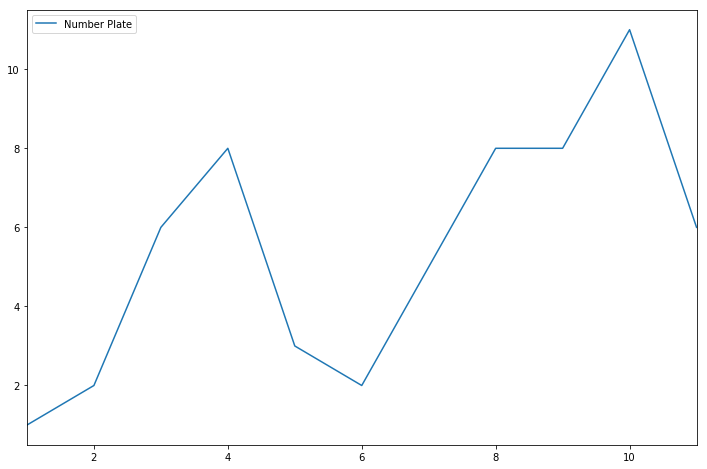

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))
sorted_data_frame.plot(ax=ax)

#### prepare the dataset for an rnn network and train the network

In [132]:
dataset= sorted_data_frame.copy()
dataset['Years']=dataset.index
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split( dataset['Years'], dataset['Number Plate'], test_size=0.20)

#reshape input to be [samples, time steps, features]
x_train = np.reshape(X_train, (X_train.shape[0], 1,1))
x_test = np.reshape(X_test, (X_test.shape[0], 1,1))
#create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1000, batch_size=1, verbose=0)
#make predictions
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)

C:\Users\NDIRANGU\Anaconda3\envs\py35\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


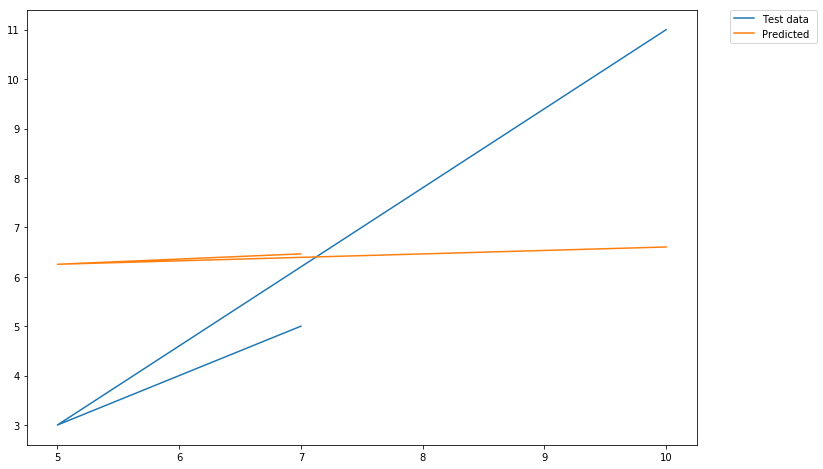

In [137]:
# Due to the small data it's hard to estimate collectly hence the 
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(X_test,y_test,label="Test data")
plt.plot(X_test,testPredict,label="Predicted ")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Predict next years vehicles to be added to fleet

In [134]:
next_year=np.reshape([12], (1, 1,1))


In [135]:
model.predict(next_year)

array([[ 6.60325956]], dtype=float32)

### The model predicts around 7 cars to be added